<br>
<hr>
**“You don't have to be great to start, but you have to start to be great.”** ~ Zig Ziglar
<hr>
<br>

Hey friends,<br>
this is a gentle introduction into Image Classification with the Python library fast.ai.

What do you need to get started?
- basic coding skills in Python
- some familiarity with fast.ai (at least the first video of the course)

[click if you don't know how to code at all](https://www.codecademy.com/learn/learn-python-3)<br>
[click if you know some coding, but not Python](https://developers.google.com/edu/python/)<br>
[click if you don't know the fast.ai course](https://course.fast.ai/videos/?lesson=1)

Feel free to fork and tweak constants to improve accuracy. Just by doing so, I was able to get a score of 99.32% easily.

Check out the [Q&A section](#Questions-and-Answers) of this notebook. If you have any questions or certain explanations weren't completely clear, let me know in the comments. I'm happy to help everyone :)

1. [Preparation](#Preparation)
2. [Training](#Training)
3. [Evaluation](#Evaluation)
4. [Prediction](#Prediction)
5. [Questions and Answers](#Questions-and-Answers)

[click for fast.ai documentation](https://docs.fast.ai)


## Preparation
first of all make sure you enabled GPU so the CNN trains faster

#### Setup environment and import necessary modules

In [1]:
# the following three lines are suggested by the fast.ai course
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# hide warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
# the fast.ai library
from fastai import *
from fastai.vision import *

# to inspect the directory
import os
from pathlib import Path

# for data manipulation (in this Kernel mainly used to read .csv files)
import pandas as pd

# for numerical analysis
import numpy as np

# to display imags
from PIL import Image

#### Inspect and understand input data
The first step in most competitions is to check out the input data. Let's do this:

In [4]:
INPUT = Path("../input/digit-recognizer")
os.listdir(INPUT)

['test.csv', 'train.csv', 'sample_submission.csv']

We found 3 interesting files:
- sample_submission.csv
- train.csv
- test.csv

'sample_submission.csv' will show us, how we have to structure our data at the end before we submit it to the competition. We will only need this file at the end.

'train.csv' is a file that contains all necessary information for training the CNN

'test.csv' is the file we later use to test how good our CNN is

Let's look at 'train.csv' and 'test.csv' to see how the data looks

In [5]:
train_df =  pd.read_csv(INPUT/"train.csv")
train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df =  pd.read_csv(INPUT/"test.csv")
test_df.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The data looks very interesting. Let's summarize what we got here:

What we know about 'train.csv':
- Each row is one image
- The first row of each image is the label. It tells us which digit is shown.
- The other 784 rows are the pixel for each digit and should be read like this

`000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783`

What we know about 'test.csv':
- The structure is the same as in train.csv, but there are no labels because it's our task to predict the labels

To read more about the data, read the ['Data' tab of the competition](https://www.kaggle.com/c/digit-recognizer/data)

#### Getting the data into the right format
Looking at the [fast.ai documentation](https://docs.fast.ai/vision.data.html#ImageDataBunch) we can quickly see, that only accepts image files for Computer Vision. In this competition we were not offered images, but csv files where each cell is one pixel. If we want to use fast.ai we have to create images from the data we have.

Fast.ai accepts image data in different formats. We will use the from_folder function of the ImageDataBunch class to load in the data. To do this we need all images in the following structure:

`path\
  train\
    0\
      ___.jpg
      ___.jpg
      ___.jpg
    1\
      ___.jpg
      ___.jpg
    2\
      ...
    3\
      ...
    ...
  test\
    ___.jpg
    ___.jpg
    ...
`

Let's first create the folder structure!

(nice to know: the input folder of Kaggle Competitions is always read-only, so if we want to add data or create folders, we have to do so outside of the input folder)

In [7]:
TRAIN = Path("../train")
TEST = Path("../test")

In [8]:
# Create training directory
for index in range(10):
    try:
        os.makedirs(TRAIN/str(index))
    except:
        pass

In [9]:
# Test whether creating the training directory was successful
sorted(os.listdir(TRAIN))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [10]:
#Create test directory
try:
    os.makedirs(TEST)
except:
    pass

Okay, all folders are created! The next step is to create the images inside of the folders from 'train.csv' and 'test.csv'. We will use the Image module from PIL to do this.


we have to reshape each numpy array to have the desired dimensions of the image (28x28)

`000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783`

then we use the fromarray function to create a .jpg image from the numpy array and save it into the desired folder

In [11]:
# save training images
for index, row in train_df.iterrows():
    
    label,digit = row[0], row[1:]
    
    filepath = TRAIN/str(label)
    filename = f"{index}.jpg"
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(filepath/filename)

In [12]:
# save testing images
for index, digit in test_df.iterrows():

    filepath = TEST
    filename = f"{index}.jpg"
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(filepath/filename)

Display some images

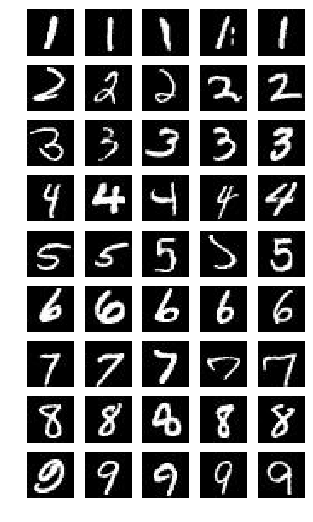

In [13]:
def displayRandomImagesFromEveryFolder(directory=TRAIN, samplesPerDigit=5):

    fig = plt.figure(figsize=(5,10))
    
    for rowIndex in range(1, 10):
        subdirectory = str(rowIndex)
        path = directory/subdirectory
        images = os.listdir(path)
        for sampleIndex in range(1,samplesPerDigit+1):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(path/images[randomNumber])
            ax = fig.add_subplot(10, 5, samplesPerDigit*rowIndex + sampleIndex)
            ax.axis("off")
            
            plt.imshow(image, cmap='gray')
            
    
    plt.show()
    
displayRandomImagesFromEveryFolder()

### Load data into DataBunch

Now that we have the right folder structure and images inside of the folders we can continue.
Before training a model in fast.ai, we have to load the data into a [DataBunch](https://docs.fast.ai/basic_data.html#DataBunch), in this case, we use a ImageDataBunch, a special version of the DataBunch.
Fast.ai offers different functions to create a DataBunch. We will use the from_folder method of the ImageDataBunch class to create the dataset.
There are different hyperparameters we can tweak to make the model perform better:
- [valid_pct](#What-are-Train,-Test-and-Validation-datasets?)
- [bs (batch size)](#What-is-the-batch-size?)
- [size](#What-image-size-should-I-choose?)
- [num_workers](#What-is-multiprocessing?)
- [ds_tfms](#What-are-transforms-and-which-transforms-should-I-use?)

In [14]:
flip_tfm = RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=1, resolved={}, do_run=True, is_random=True, use_on_y=True)
random_number = str(3)
random_filename = os.listdir(TRAIN/random_number)[0]
img = open_image(TRAIN/random_number/random_filename)
display(img)
display(img.apply_tfms(flip_tfm))

In [15]:
# transforms
tfms = get_transforms(do_flip=False, max_zoom=1.2)

In [16]:
data = ImageDataBunch.from_folder(
    path = TRAIN,
    test = TEST,
    valid_pct = 0.2,
    bs = 32,
    size = 28,
    ds_tfms = tfms,
    #num_workers = 0
)

Let's perform normalization to make the CNN converge faster. fast.ai already defined the variable mnist_stats, that we can use to normalize our data. Alternatively, we can call normalize() without any paramters. In this case fast.ai simply calculates the exact stats needed for the dataset at hand.

In [17]:
mnist_stats

([0.15, 0.15, 0.15], [0.15, 0.15, 0.15])

In [18]:
data.normalize(mnist_stats)

ImageDataBunch;

Train: LabelList (33600 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
5,5,5,5,5
Path: ../train;

Valid: LabelList (8400 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,3,3,7,2
Path: ../train;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: ../train

In [19]:
# all the classes in data
print(data.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Training

The next step is to select and create a CNN. In fast.ai creating a CNN is really easy. You just have to select one of the models from the [Computer Vision models zoo](https://docs.fast.ai/vision.models.html#Computer-Vision-models-zoo). Parameters to tweak: dropout propability: ps (default: 0.5)

In [20]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, model_dir="/tmp/models", callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.4MB/s]


Now it's time to train the neural network using the fit_one_cycle() function. <br>Parameters to modify: the number of epochs(cyc_len) to train, the learning rate(max_lr) and the momentum (moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.035955,0.827222,0.743214,01:19
1,0.569746,0.350490,0.887381,01:18
2,0.382743,0.207637,0.935000,01:19
3,0.301313,0.173938,0.947262,01:18
4,0.272638,0.155879,0.953452,01:18


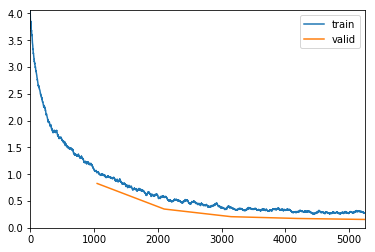

In [21]:
learn.fit_one_cycle(cyc_len=5)

## Evaluation
Create a ClassificationInterpretation object to evaluate your results.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

Plot the 9 images with the highest loss. These are the images the CNN was most sure about, but still got wrong.

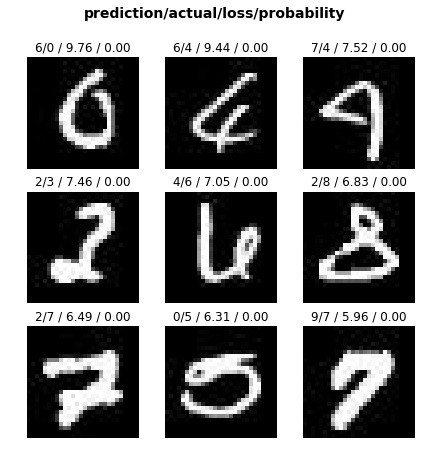

In [23]:
interp.plot_top_losses(9, figsize=(7, 7))

A good way to summarize the performance of a classification algorithm is to create a confusion matrix. Confusion Matricies are used to understand which classes are most easily confused. As labeled on the axis, the x-axis shows the predicted classes and the y-axis the actual classes. So if (4/7)=10 it means that it happened 10 times that the CNN predicted a 7 but in reality if was a 4.

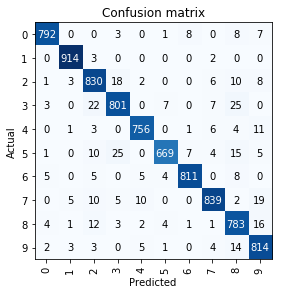

In [24]:
interp.plot_confusion_matrix()

## Prediction

Get the predictions on the test set.<br>
learn.get_preds() returns a propability distribution over all possible classes for every given image.

In [25]:
class_score, y = learn.get_preds(DatasetType.Test)

That means that for every image in the test set it predicts how likely each class is. In this case the highest value is obviously 1

In [26]:
probabilities = class_score[0].tolist()
[f"{index}: {probabilities[index]}" for index in range(len(probabilities))]

['0: 0.00013247427705209702',
 '1: 0.9994269609451294',
 '2: 5.632105967379175e-05',
 '3: 1.3070153727312572e-05',
 '4: 7.0529308686673176e-06',
 '5: 5.348992999643087e-06',
 '6: 9.541482722852379e-05',
 '7: 0.00022122538939584047',
 '8: 9.339080861536786e-06',
 '9: 3.278087024227716e-05']

But we want the CNN to predict only one class. The class with the highest probability.
Argmax returns the index of the highest value.

In [27]:
class_score = np.argmax(class_score, axis=1)

This is exactly what we want. 

In [28]:
class_score[0].item()

1

The last step is creating the submission file.<br>"sample_submission.csv" is showing us the desired format

In [29]:
sample_submission =  pd.read_csv(INPUT/"sample_submission.csv")
display(sample_submission.head(2))
display(sample_submission.tail(2))

,ImageId,Label
0,1,0
1,2,0


,ImageId,Label
27998,27999,0
27999,28000,0


Columns the submission file has to have:
- ImageId: index in the test set, starting from 1, going up to 28000
- Label: a prediction which digit the image shows

In [30]:
# remove file extension from filename
ImageId = [os.path.splitext(path)[0] for path in os.listdir(TEST)]
# typecast to int so that file can be sorted by ImageId
ImageId = [int(path) for path in ImageId]
# +1 because index starts at 1 in the submission file
ImageId = [ID+1 for ID in ImageId]

In [31]:
submission  = pd.DataFrame({
    "ImageId": ImageId,
    "Label": class_score
})
# submission.sort_values(by=["ImageId"], inplace = True)
submission.to_csv("submission.csv", index=False)
display(submission.head(3))
display(submission.tail(3))

,ImageId,Label
0,21368,1
1,26151,0
2,21961,1


,ImageId,Label
27997,19739,4
27998,8680,8
27999,43,4


## Questions and Answers
- [What are Train, Test and Validation datasets?](#What-are-Train,-Test-and-Validation-datasets?)
- [What is the batch size?](#What-is-the-batch-size?)
- [What image size should I choose?](#What-image-size-should-I-choose?)
- [What is multiprocessing?](#What-is-multiprocessing?)
- [What are transforms and which transforms should I use?](#What-are-transforms-and-which-transforms-should-I-use?)
- [How to improve your score?](#How-to-improve-your-score?)
- [What is the best CNN architecture?](#What-is-the-best-CNN-architecture?)
- [How to submit?](#How-to-submit?)


### What are Train, Test and Validation datasets?
Whenever we train a CNN we need to split the data into 3 parts:
- training set: used to modify weights of neural network
- validation set: prevent overfitting
- test set: test accuracy of fully-trained model

In this kernel we only have a training and a test set. That's why we split the test set to get a validation set. We do this with the 'valid_pct' parameter. This is one of the parameters you could tune to increase the accuracy. To learn more about this read [this stackoverflow post](https://stackoverflow.com/a/13623707)

### What is the batch size?
The batch size refers to the number of images in one batch. Everytime an entire batch of images is passed through the neural network the weights of the neural network are updated
<br><br>Why would you increase the batch size:
- to improve accuracy of the model

<br>Why would you decrease the batch size:
- to train the network faster
- to reduce the memory used

### What image size should I choose?

(Most) CNNs need images of the same size. By setting the size parameter we tell fast.ai to make all images that size.

Bigger images, result in more calculations and thus slower speed, but the accuracy improves. Smaller images on the other hand reduce accuracy but improve speed.
Don't make the trainig images bigger than the original images, as this would only be a waste of time.

Our data is already of shape 28x28.

We could make the images smaller than 28x28. This would decrease the training time, but also decrease the accuracy. Because our CNN trains in a reasonable amount of time there is no reason to decrease the image size

Never make the training image bigger than the original image.

### What is multiprocessing?
In Computer Science there is this thing called multiprocessing. This means that we have two or more things happending at the same time. A computer typically has multiple CPUs and we make use of exactly that. Every CPU can run one process at a time. Ususally when we do multiprocessing every CPU gets its own task.
Exactly that is the default for ImageDataBunch: number workers = number of CPUs. This works fine for Linux, but makes a lot of problems in Windows. If you're on Windows, set num_workers to 0, if you're on Linux, don't set anything, then it defaults to the number of CPUs

If you use a cloud solution and are not sure which operating system is used, execute the following code
> import platform; platform.system()

### What are transforms and which transforms should I use?
To make models generalize better we can use so called transforms. They randomly change the image slightly. For example a bit of zoom or rotation. Fortunately, we don't really have to deal with transforms a lot in fast.ai. The package offers a convenient function called get_transforms() that returns pretty good values for transformations.
In the case of digit recognition we want to tranform the data as much as possible so that it generalizes better, but only so much that the image would still be recognized by a human being.
One parameter we definitely have to change for that reason is do_flip. If this is activated, random flips (with a probability of 0.5) would be applied to the images. We don't want that. The next two images are an image of the number three and another image of a number three that is flipped horizontally. This would confuse our CNN.

### How to improve your score?
add special features
- pooling layers
- data augmentation
- dropout
- batch normalization
- decaying learning rate
- advanced optimization

[source](https://www.kaggle.com/c/digit-recognizer/discussion/61480)

### What is the best CNN architecture?
According to [this post](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist) by [Chris Deotte](https://www.kaggle.com/cdeotte) the best architecture is:
> 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10
> with 40% dropout, batch normalization, and data augmentation added

784 input nodes

[32C3-32C3-32C5S2]
- 2x (convolutional layer with 32 feature maps, 3x3 filter and stride 1)
- convolutional layer with 32 feature maps, 5x5 filter and stride 2

[64C3-64C3-64C5S2]
- 2x (convolutional layer with 64 feature maps, 3x3 filter and stride 1)
- convolutional layer with 64 feature maps, 5x5 filter and stride 2 

128 fully connected dense layers

10 output nodes



### What is the best possible score?
The best score inside of Kernels is [99.75%](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist).

The best score anywhere is [99.79%](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf).

### How to submit?
Now we're throught the entire process of how to create a CNN with fast.ai to recognize digits. To submit a file to the the competition, you have two different options.
#### Code in Kaggle Kernel
1. go to the kernel
2. commit the kernel
3. go back to all of your kernels
4. select the kernel again
5. scroll down to Output
6. click on "Submit to Competition"

#### Code locally on PC
1. go to [the competition](https://www.kaggle.com/c/digit-recognizer)
2. click on ["Submit Predictions"](https://www.kaggle.com/c/digit-recognizer/submit)
3. upload your submission file
4. add a description
5. click on submit

TODO:
- image augmentation
https://www.kaggle.com/anisayari/generate-more-training-data-fastai
- created images to zip file
https://www.kaggle.com/anisayari/generate-more-training-data-fastai
- better comments
- add images to "How to Submit"
- explain normalization better